## Load configuration

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from src.utils.config_loader import load_config
cfg = load_config("../config.yaml")
data_cfg = cfg['data']
model_cfg = cfg['model']
training_cfg = cfg['training']

model_parameters = {
    'n':{'csp': [False, True], 'depth' : [1, 1, 1, 1, 1, 1], 'width' : [3, 16, 32, 64, 128, 256]},
    's':{'csp': [False, True], 'depth' : [1, 1, 1, 1, 1, 1], 'width' : [3, 32, 64, 128, 256, 512]},
    'm':{'csp': [True, True], 'depth' : [1, 1, 1, 1, 1, 1], 'width' : [3, 64, 128, 256, 512, 512]},
    'l':{'csp': [True, True], 'depth' : [2, 2, 2, 2, 2, 2], 'width' : [3, 64, 128, 256, 512, 512]},
    'x':{'csp': [True, True], 'depth' : [2, 2, 2, 2, 2, 2], 'width' : [3, 96, 192, 384, 768, 768]},
}

## Load Data Sample

In [3]:
from src.data.data_loader import get_data_loaders

In [ ]:
train_loader, val_loader = get_data_loaders(
    "../" + data_cfg['train_parquet'],
    "../" + data_cfg['val_parquet'],
    "../" + data_cfg['train_images'],
    "../" + data_cfg['val_images'],
    # training_cfg['batch_size']
    4,
    isTest=True
)
print("Loaded train and validation data loaders")

[INFO] Loaded parquet file - ../dataset/processed/parquet/annotations_train.parquet
[INFO] Reducing data for test
[INFO] Parsing column 'bbox' using 12 workers...
[INFO] Parsing column 'segmentation' using 12 workers...
[INFO] Parsing column 'category_id' using 12 workers...
[INFO] Parsing column 'area' using 12 workers...
[INFO] Loaded parquet file - ../dataset/processed/parquet/annotations_val.parquet
[INFO] Reducing data for test
[INFO] Parsing column 'bbox' using 12 workers...
[INFO] Parsing column 'segmentation' using 12 workers...
[INFO] Parsing column 'category_id' using 12 workers...
[INFO] Parsing column 'area' using 12 workers...
[INFO] Creating Train Loader...

[INFO] Creating Val Loader...
Loaded train and validation data loaders


In [5]:
len(train_loader), len(val_loader)

(125, 125)

In [6]:
images, targets = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


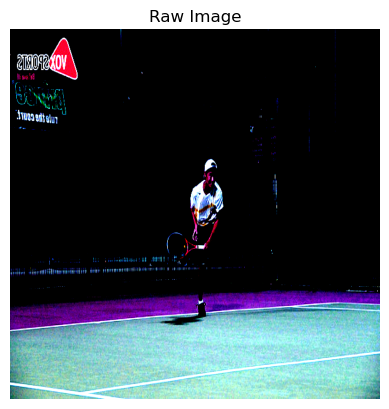

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


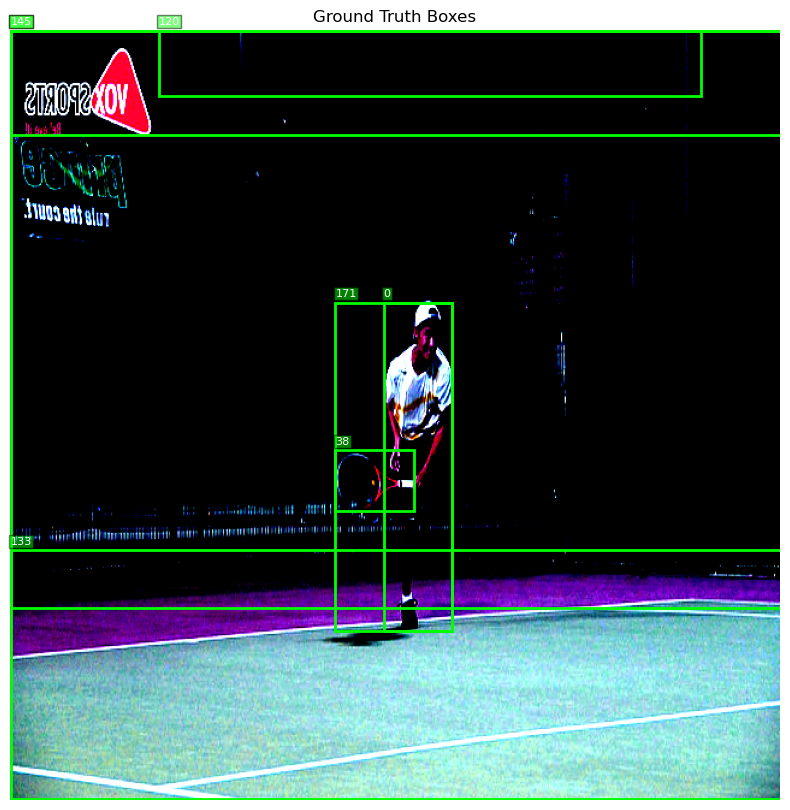

In [7]:
from src.data.visualization import visualize_comparison

visualize_comparison(images[0], targets[0])

## Training loop

In [8]:
from src.training.train_model import train
from src.model.losses import YoloDFLQFLoss
from src.training.utils_train import get_optimizer

In [9]:
import torch
from src.model.model_builder import Model

model = Model(**model_parameters['m'], num_classes=model_cfg['num_classes']).cuda()

In [10]:
optimizer, scheduler = get_optimizer(
    model,
    training_cfg['learning_rate'],
    training_cfg['weight_decay'],
    training_cfg['learning_rate_patience'],
    training_cfg['learning_rate_factor']
)

In [11]:
criterion = YoloDFLQFLoss(
    num_classes=model_cfg['num_classes'],
    lambda_box=training_cfg.get('lambda_box', 1.5),
    lambda_cls=training_cfg.get('lambda_cls', 1.0)
)

In [13]:
train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    # num_epochs=training_cfg["epochs"],
    num_epochs=2,
    device=0,
    num_classes=model_cfg['num_classes'],
    rank=0,
    use_wandb=False,
    wandb_instance=None,
    log_interval=training_cfg.get('log_interval', 10),
    checkpoint_dir=os.path.join("..", training_cfg.get('checkpoint_dir', 'experiments/checkpoints')),
    iou_threshold=training_cfg.get('iou_threshold', 0.5),
    conf_threshold=training_cfg.get('conf_threshold', 0.25)
)

[Epoch 1/2] Validation: 100%|██████████| 125/125 [01:51<00:00,  1.12it/s, Loss=223.3050, Box=105.1221, Cls=65.6218]



Epoch 1/2 Summary:
  Train - Total: 369.1645 | Box: 229.8858 | Cls: 24.3358
  Val   - Total: 223.3050 | Box: 105.1221 | Cls: 65.6218
  Metrics - Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | mAP: 0.0000
  Detection - TP: 0 | FP: 50000 | FN: 6719
  LR: 0.000100



[Epoch 2/2] Validation: 100%|██████████| 125/125 [01:55<00:00,  1.08it/s, Loss=219.1243, Box=106.0551, Cls=60.0417]



Epoch 2/2 Summary:
  Train - Total: 332.3470 | Box: 218.2139 | Cls: 5.0261
  Val   - Total: 219.1243 | Box: 106.0551 | Cls: 60.0417
  Metrics - Precision: 0.0000 | Recall: 0.0003 | F1: 0.0001 | mAP: 0.0000
  Detection - TP: 2 | FP: 49998 | FN: 6717
  LR: 0.000100



In [ ]:
# ## Initialize the model
# import torch
# from src.model.model_builder import DetectionModel
# model = DetectionModel(num_classes=cfg["project"]["num_classes"]).cuda()
# from torchinfo import summary
# summary(model, input_size=(1, 3, 640, 640))
# from torchview import draw_graph

# draw_graph(model, input_size=(1, 3, 640, 640))
# # model.eval()
# # with torch.no_grad():
# #     preds = model(images.cuda())
# # preds
# # targets[0]['boxes'].cpu().numpy()
# # from src.data.visualization import visualize_comparison

# # visualize_comparison(images[0], targets[0], prediction=preds[0])

In [ ]:
# ## Model Initialization
# import torch
# from src.model.model_builder import Model

# example_input = (1, 3, 640, 640)
# example_data = torch.rand(example_input).cuda()
# def create_model(obj_params):
#     model = Model(**obj_params, num_classes=171)
#     return model.cuda()
# def visualize_graph(model, input_data, filename: str = 'Model'):
#     from torchview import draw_graph
#     from IPython.display import Image, display

#     model_graph = draw_graph(model, input_data=input_data, graph_name=filename, save_graph=True, expand_nested=True, depth=10)
#     # img_bytes = model_graph.visual_graph.render(format='png')
#     # # display(Image(data=img_bytes, format='png'))
# model = create_model(model_parameters['n'])
# model.eval()
# output = model(example_data)
# output.shape
# preds = output.transpose(1, 2)
# preds.shape
# pred_box = preds[0][:, 0:4]
# pred_scores = preds[0][:, 4:]
# pred_box.shape, pred_scores.shape

# model = create_model(model_parameters['n'])
# visualize_graph(model, example_data, "Model - nano")
# model = create_model(model_parameters['s'])
# visualize_graph(model, example_data, "Model - small")
# model = create_model(model_parameters['m'])
# visualize_graph(model, example_data, "Model - medium")
# model = create_model(model_parameters['l'])
# visualize_graph(model, example_data, "Model - large")
# model = create_model(model_parameters['x'])
# visualize_graph(model, example_data, "Model - xlarge")